In [61]:
def get_slop(df2,from_date,to_date):
    datelist = pd.date_range(start=from_date, end=to_date, freq = 'M').tolist()
    dtlst = []
    df = df2.copy()
    for d_t in datelist:
        d_t = str(d_t)[0:-9]
        d = datetime.strptime(d_t, '%Y-%m-%d')
        d = d.strftime('%Y%m')
        dtlst.append(d)
    for dt in dtlst:
        df[dt] = df[dt][:-1]*10000 / df[dt][-1]
    from scipy import stats

    x = [x + 1for x in range(0,len(dtlst))]

    slopes = []
    for i in list(df.values):
        y = i[:-1]
        slope, intercept, r, p, std_err = stats.linregress(x, y)
        slopes.append(slope)
    df['slope'] = slopes
    return df

In [6]:
def data_pro(data,from_date,to_date):

    df = data[['일자','키워드']]
    df['일자'] = [str(x)[0:6] for x in df['일자']] 

    datelist = pd.date_range(start=from_date, end=to_date, freq = 'M').tolist()
    dtlst = []

    for d_t in datelist:
        d_t = str(d_t)[0:-9]
        d = datetime.strptime(d_t, '%Y-%m-%d')
        d = d.strftime('%Y%m')
        dtlst.append(d)

    # 키워드 사전 
    keyword_vocab = []
    for i in df['키워드']:
        keyword_vocab.extend(i)
    keyword_vocab = list(set(keyword_vocab))

    # 월별 카운팅 후 병합 # 병합하는 방식 수정해야함. 한달만 카운트는 현재 불가.
    from collections import Counter

    tmp_df_list = []
    for dt in dtlst:
        tmp = []
        for i in df[df['일자']== dt]['키워드']:
            tmp.extend(i)
        tmp_df = pd.DataFrame(pd.Series(Counter(tmp)))
        tmp_df = tmp_df.reset_index()
        tmp_df = tmp_df.rename(columns = {0:'cnt','index':'keyword'})
        tmp_df_list.append(tmp_df)

    df = tmp_df_list[0].merge(tmp_df_list[1], on = 'keyword', how = 'outer')
    for i in range(len(tmp_df_list)):
        if i > 1:
            df = df.merge(tmp_df_list[i], on = 'keyword', how = 'outer')
    col = ['keyword'] + dtlst
    df.columns = col

    # 합산 값 만들기
    df.index = df['keyword']
    df = df.drop('keyword', axis = 1)
    df['tot_cnt'] = df.sum(axis = 1)
    df = df.T
    df['year_cnt'] = df.sum(axis = 1)
    df = df.T
    df

    # 결측치 처리
    df =df.fillna(0)
    return df

In [2]:
from datetime import datetime
import logging
import re
import numpy as np
import pandas as pd
import os
import pickle
import networkx as nx
from pyvis.network import Network

In [67]:
data_e['키워드']

0      [economic, international, world, article, anal...
1      [중소중견기업과, 개정안k칩스법이, 세액공제14일, 정부의, 유치하기, 상대적으로,...
2      [fiscal, singaporeans, inflation, sustainable,...
3      [premium, subscription, trial, access, digital...
4      [sustainability, circular, recyclable, sector,...
                             ...                        
225                                               [null]
226    [workingfromhome, deficit, commuters, tax, cen...
227    [economy, roblx, strategy, nations, advancemen...
228    [국제통화기금, 경제성장률이, 콘퍼런스에서, 충격적인, 급등세의, 생존권과, 전망치...
229    [비둘기파통화완화, 대유행팬데믹의, 백악관행을, 산탄데르은행의, 정책의, 부의장의,...
Name: 키워드, Length: 230, dtype: object

In [87]:


for i in data_e['키워드']:
    if i[0] == 'null':
        print(i[0])

null
null
null
null
null


IndexError: list index out of range

In [116]:
# datapre로 넘겨야함.
topic ='economy'
from_date = '2023-2-14'
to_date = '2023-2-14'
cwd = os.getcwd()
main_path = cwd + '/' + topic
name = "Keyword{}-{}.pickle".format(from_date,to_date)
name = name.replace('/','.')
with open(main_path + '/' + 'keyword/' + name, 'rb') as f:
    data_e = pickle.load(f)
    
data_e =  data_e[['일자','kwd']]
data_e = data_e.rename({'kwd':'키워드'},axis = 1)
data_e = data_e.explode('키워드')
data_e = data_e.reset_index(drop = True)
data_e = data_e[[x != [] for x in data_e['키워드']]]
data_e = data_e[[x[0] != 'null' for x in data_e['키워드']]]

data_e['일자'] = [int(x) for x in data_e['일자']]

to_date = '2023-04-01' # 다담달까지 넣어야함. 예) 20220214까지 집계하기 위해서는 20220401까지로 설정해야함. 혼란을 막기위해서 수정 필요! dataPro를 일별 카운팅으로 할 필요가 있겠다. 
df_e = data_pro(data_e ,from_date,to_date)

to_date = '2023-2-14' # 저장하려면 또 바꿔져야함. datapro를 일별 단위로 바꿔야 해결 가능
df_e.to_csv(cwd +'/' + topic + '/'+ 'Monthly_Count_Keyword {}-{}.csv'.format(from_date,to_date),encoding="utf-8-sig")

df_es = get_slop(df_e,from_date,to_date)
df_ss.to_csv(cwd +'/' + topic + '/'+ 'Efficient_OLS_Keyword {}-{}.csv'.format(from_date,to_date),encoding="utf-8-sig")

C:\Users\NH\AppData\Local\Temp\ipykernel_7480\2115823430.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp_df = pd.DataFrame(pd.Series(Counter(tmp)))


ValueError: Inputs must not be empty.

In [53]:
# 워드 클라우드
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [54]:
print('{}로 검색하여 {} 에 {} 건의 기사를 인용했습니다.'.format(topic,from_date,len(data_e)))

economy로 검색하여 2023-2-14 에 230 건의 기사를 인용했습니다.


In [55]:
df_e.sort_values(by = 'tot_cnt', ascending = False)[1:51]

,202302,202303,tot_cnt
keyword,,,
inflation,28.0,0.0,28.0
average,28.0,0.0,28.0
null,23.0,0.0,23.0
growth,23.0,0.0,23.0
pandemic,21.0,0.0,21.0
recession,21.0,0.0,21.0
economy,21.0,0.0,21.0
sustainable,19.0,0.0,19.0
tuesday,18.0,0.0,18.0


In [56]:
from matplotlib.pyplot import figure

In [57]:
from wordcloud import (WordCloud, get_single_color_func)

In [58]:
class SimpleGroupedColorFunc(object):
    """Create a color function object which assigns EXACT colors
       to certain words based on the color to words mapping

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.word_to_color = {word: color
                              for (color, words) in color_to_words.items()
                              for word in words}

        self.default_color = default_color

    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

<Figure size 7680x5760 with 0 Axes>

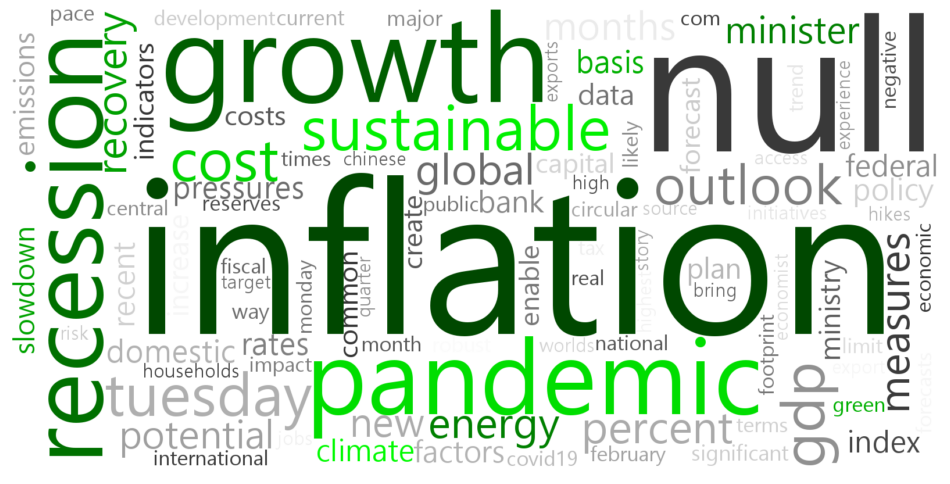

In [59]:
tags = df_e.sort_values(by = 'tot_cnt', ascending = False)[1:101]['tot_cnt']

drop_list = ['average','news','economy','sector','sectors']
tags = tags.drop(drop_list)
wc = WordCloud(font_path='C:/Windows/Fonts/malgun',background_color="white",width=1600, height=800)

color_to_words = {
    # words below will be colored with a green single color function
    '#00ff00': ['slowdown','green','inflation','basis','cost','growth','pandemic','sustainable','recovery','climate','recession','minister','energy','emmissions']
}

default_color = 'black'
grouped_color_func = GroupedColorFunc(color_to_words, default_color)



cloud = wc.generate_from_frequencies(dict(tags))
wc.recolor(color_func=grouped_color_func)


figure(dpi=1200)
figure(figsize=[12,8])
title = '대상기간_최대출현_키워드_100개'
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.savefig(cwd + '/' + topic + '/'+ title + '.pdf')
plt.show()

In [ ]:
# 키워드의 뉴스링크

In [57]:
keyword = 'inflation'

In [65]:
tmp = []

for i in data_e['키워드']:
    if keyword in i:
        tmp.append(True)
    else:
        tmp.append(False)

In [74]:
pd.DataFrame(url_e)[tmp]

ValueError: Item wrong length 205 instead of 227.

In [70]:
url_e[[tmp]]

TypeError: unhashable type: 'list'

In [16]:
# 특정키워드를 중심으로 NETWORK 생성

In [27]:
# 중심키워드 선택
main_kwd = 'finance'

# 날짜선택
from_date = 20230201
to_date = 20230401

df_nx = data_e.copy()
df_nx = df_nx[(from_date <= df_nx['일자'])  & (df_nx['일자'] <= to_date)]

# 키워드 선택
df_cnt = data_pro(df_nx,str(from_date),str(to_date))
kwd_norm =df_cnt.sort_values(by = 'tot_cnt',ascending = False)[1:1001].index


## 중심키워드와 동시출현빈도가 높은 키워드 선택 
df_nx = data_e.copy()
df_nx = df_nx[(from_date <= df_nx['일자'])  & (df_nx['일자'] <= to_date)]
# 동시출현빈도 계산
two_mode_matrix = []
for i in df_nx['키워드']:
    law_one= []
    for j in kwd_norm:
        if j in i:
            law_one.append(1.)
        else:
            law_one.append(0.)
    two_mode_matrix.append(law_one)

two_mode_matrix = np.array(two_mode_matrix)
one_mode_matrix = np.dot(two_mode_matrix.T,two_mode_matrix)

# 자신 제외 20개 키워드 선택
kwd_norm = pd.DataFrame(one_mode_matrix, index = kwd_norm, columns = kwd_norm).T[main_kwd].sort_values(ascending= False)[0:21].index

# 선별된 키워드로 다시 네트워크 생성
df_nx = data_e.copy()
df_nx = df_nx[(from_date <= df_nx['일자'])  & (df_nx['일자'] <= to_date)]
# 동시출현빈도 계산
two_mode_matrix = []
for i in df_nx['키워드']:
    law_one= []
    for j in kwd_norm:
        if j in i:
            law_one.append(1.)
        else:
            law_one.append(0.)
    two_mode_matrix.append(law_one)

two_mode_matrix = np.array(two_mode_matrix)
one_mode_matrix = np.dot(two_mode_matrix.T,two_mode_matrix)

# NETWORK 생성
net = Network(notebook=True,select_menu=True, filter_menu=True,  cdn_resources='remote') #  

# 동시출현빈도 로 노드크기 설정 후 노드 추가
sizes = (one_mode_matrix[0] / one_mode_matrix[0].sum())*200
for idx, label in enumerate(kwd_norm):
    if idx != 0:
        net.add_node(idx, size = sizes[idx],label=label, title = '동시출현 {}건'.format(str(one_mode_matrix[0][idx])))
    else:
        net.add_node(idx, size = 10,label=label, title = '동시출현 0건')

# 동시출현빈도가 평균 이상인 엣쥐만 살리고 나머지는 0으로 변경
edge_matrix = one_mode_matrix.copy()
norm = one_mode_matrix.sum() / (len(one_mode_matrix)*len(one_mode_matrix))
for idx, _ in enumerate(one_mode_matrix):
    edge_matrix[idx] = np.multiply(edge_matrix[idx],edge_matrix[idx] >= norm)

# 동시출현빈도로 엣쥐너비 설정 (optional)
for u in range(len(edge_matrix )):
    for v in range(len(edge_matrix )):
        if edge_matrix [u,v] != 0 and u != v:
            net.add_edge(u,v) #  width = edge_matrix [u,v]
            
            
# SHOW NETWORK
net.show_buttons()
# net.set_options()
net.show('my.html')

C:\Users\NH\AppData\Local\Temp\ipykernel_36800\2115823430.py:29: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  tmp_df = pd.DataFrame(pd.Series(Counter(tmp)))
